In [293]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import init
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np
from IPython.display import clear_output
from IPython.display import HTML
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch
from functools import partial
import random
import os
import io
from PIL import Image
from utils import generate_dataset

/var/folders/n_/ykwl_b5n0gx9x4hp5z0fmvvr0000gn/T/ipykernel_79330/132172499.py:9: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [294]:
seed = 999
random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed) 
np.random.seed(seed) 
torch.cuda.manual_seed(seed) 
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False 
scatter_range = [-0.5, 0.5]

In [295]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / torch.Tensor([d_model]) * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, d_model // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, d_model // 2, 2]
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb

In [296]:

class MLPDiffusion(nn.Module):
    def __init__(self, T, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.time_embeddings = nn.ModuleList( # 用于生成t的embedding
            [
                TimeEmbedding(T, num_units, num_units),
                TimeEmbedding(T, num_units, num_units),
                TimeEmbedding(T, num_units, num_units),
            ]
        )
    def forward(self, x, t):
        """ 生成的过程: 把t的值作为一个embedding,然后和x相加
        下边的循环等价于把每个nn.Embedding分别插入到每个nn.Linear之前
        """
        for idx, embedding_layer in enumerate(self.time_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)

        return x
'''

class MLPDiffusion(nn.Module):
    def __init__(self, T, num_units=128):
        super(MLPDiffusion, self).__init__()
        self.time_embeddings1 = TimeEmbedding(T, num_units, num_units)
        self.time_embeddings2 = TimeEmbedding(T, num_units, num_units)
        self.time_embeddings3 = TimeEmbedding(T, num_units, num_units)
        self.fc1 = nn.Sequential(
            nn.Linear(2, num_units),
            nn.GELU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(num_units, num_units),
            nn.GELU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(num_units, num_units),
            nn.GELU(),
        )
        self.fc4 = nn.Linear(num_units, 2)
        self.initialize()
    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
    
    def forward(self, x, t):
        """ 生成的过程: 把t的值作为一个embedding,然后和x相加
        下边的循环等价于把每个nn.Embedding分别插入到每个nn.Linear之前
        """
        t_embedding1 = self.time_embeddings1(t)
        x = self.fc1(x)
        x += t_embedding1
        t_embedding2 = self.time_embeddings2(t)
        x = self.fc2(x)
        x += t_embedding2
        t_embedding3 = self.time_embeddings3(t)
        x = self.fc3(x)
        x += t_embedding3
        x = self.fc4(x)
        return x
'''

'\n\nclass MLPDiffusion(nn.Module):\n    def __init__(self, T, num_units=128):\n        super(MLPDiffusion, self).__init__()\n        self.time_embeddings1 = TimeEmbedding(T, num_units, num_units)\n        self.time_embeddings2 = TimeEmbedding(T, num_units, num_units)\n        self.time_embeddings3 = TimeEmbedding(T, num_units, num_units)\n        self.fc1 = nn.Sequential(\n            nn.Linear(2, num_units),\n            nn.GELU(),\n        )\n        self.fc2 = nn.Sequential(\n            nn.Linear(num_units, num_units),\n            nn.GELU(),\n        )\n        self.fc3 = nn.Sequential(\n            nn.Linear(num_units, num_units),\n            nn.GELU(),\n        )\n        self.fc4 = nn.Linear(num_units, 2)\n        self.initialize()\n    def initialize(self):\n        for module in self.modules():\n            if isinstance(module, nn.Linear):\n                init.xavier_uniform_(module.weight)\n                init.zeros_(module.bias)\n    \n    def forward(self, x, t):\n   

In [297]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''

        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = MLPDiffusion(T)
        
        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x, idx=None, get_target=False):
        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

        output = self.backbone(x_tilde, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output

In [298]:
class DiffusionProcessDDIM():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape, eta, tau = 1, scheduling = 'uniform'):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        eta           : coefficient of sigma
        tau           : accelerating of diffusion process
        scheduling    : scheduling mode of diffusion process
        '''
        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])

        self.shape = shape
        self.sigmas = torch.sqrt((1 - self.alpha_prev_bars) / (1 - self.alpha_bars)) * torch.sqrt(1 - (self.alpha_bars / self.alpha_prev_bars))
        self.diffusion_fn = diffusion_fn
        self.device = device
        self.eta = eta
        self.tau = tau
        self.scheduling = scheduling
        
    def _get_process_scheduling(self, reverse = True):
        if self.scheduling == 'uniform':
            diffusion_process = list(range(0, len(self.alpha_bars), self.tau)) + [len(self.alpha_bars)-1]
        elif self.scheduling == 'exp':
            diffusion_process = (np.linspace(0, np.sqrt(len(self.alpha_bars)* 0.8), self.tau)** 2)
            diffusion_process = [int(s) for s in list(diffusion_process)] + [len(self.alpha_bars)-1]
        else:
            assert 'Not Implementation'
            
        
        diffusion_process = zip(reversed(diffusion_process[:-1]), reversed(diffusion_process[1:])) if reverse else zip(diffusion_process[1:], diffusion_process[:-1])
        return diffusion_process
            

    
    def _one_reverse_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        diffusion_process = self._get_process_scheduling(reverse = True)

        for prev_idx, idx in diffusion_process:
            self.diffusion_fn.eval()
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            predict_epsilon = self.diffusion_fn(x, idx)
            sigma = self.sigmas[idx] * self.eta
            
            predicted_x0 = torch.sqrt(self.alpha_bars[prev_idx]) * (x - torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon) / torch.sqrt(self.alpha_bars[idx])
            direction_pointing_to_xt = torch.sqrt(1 - self.alpha_bars[prev_idx] - sigma**2 ) * predict_epsilon
            x = predicted_x0 + direction_pointing_to_xt + sigma * noise

            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, sample=None, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if sample==None:
            sample = torch.randn([sampling_number,self.shape]).to(device = self.device)
            
        sampling_list = []
        
        final = None
        for sample in self._one_reverse_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

    
    @torch.no_grad()
    def probabilityflow(self, x, reverse):
        '''
        reverse : if True, backward(noise -> data) else forward(data -> noise)
        '''
        def reparameterize_sigma(idx):
            return torch.sqrt( (1-self.alpha_bars[idx]) / self.alpha_bars[idx] )
        def reparameterize_x(x, idx):
            return x / torch.sqrt(self.alpha_bars[idx])
        
        diffusion_process = self._get_process_scheduling(reverse = reverse)
        for idx_delta_t, idx in diffusion_process:
            self.diffusion_fn.eval()
            x_bar_delta_t = reparameterize_x(x, idx) + 0.5 * (reparameterize_sigma(idx_delta_t)**2 - reparameterize_sigma(idx)**2) / reparameterize_sigma(idx) * self.diffusion_fn(x, idx)
            x = x_bar_delta_t * torch.sqrt(self.alpha_bars[idx_delta_t])

        return x

In [299]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [300]:
def make_grid(sample, sampling_number = 64):
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255
            
    show_sample = show_sample.astype(np.uint8)
    return show_sample

In [301]:
def imshow(sample, sampling_number = 64):
    plt.figure(figsize=(10, 10))
    clear_output()
    show_sample = make_grid(sample, sampling_number)

    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()

In [302]:
def scatter(samples):
    clear_output()
    plt.figure(figsize=(6, 6))
    plt.xlim(scatter_range)
    plt.ylim(scatter_range)
    plt.axis('off')
    plt.scatter(samples[:, 0], samples[:, 1], s=3)
    plt.show()

In [303]:
beta_1 = 1e-4
beta_T = 0.02
T = 2000
shape = 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
eta = 1
tau = 1
model = Model(device, beta_1, beta_T, T)
process = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
optim = torch.optim.Adam(model.parameters(), lr = 0.0005)

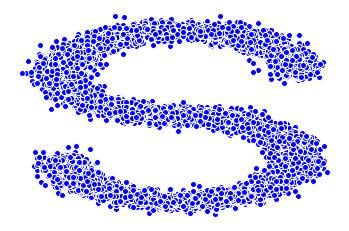

In [304]:
total_iteration = 100000
current_iteration = 0
display_iteration = 2000


sampling_number = 1500
only_final = True

data = generate_dataset(10000)
dataset = torch.utils.data.TensorDataset(data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128, shuffle = True)
dataiterator = iter(dataloader)

losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

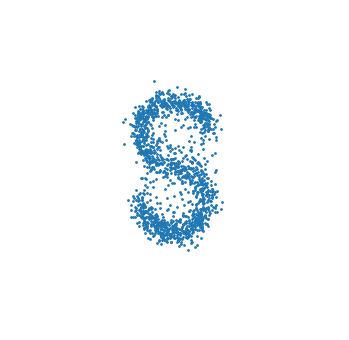

In [305]:
while current_iteration != total_iteration:
    try:
        data = dataiterator.__next__()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.__next__()
    data = data[0].to(device = device)
    loss = model.loss_fn(data)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    losses.update(loss.item())
    progress.display(current_iteration)
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        process = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
        samples = process.sampling(sampling_number, only_final = only_final)
        scatter(samples)
        losses.reset()

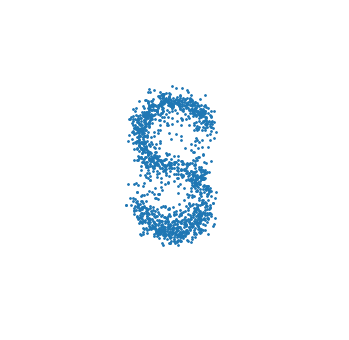

In [306]:
process = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, 1)
samples = process.sampling(sampling_number, only_final = only_final)
scatter(samples)

In [327]:
samples = process.sampling(5000, only_final = False)

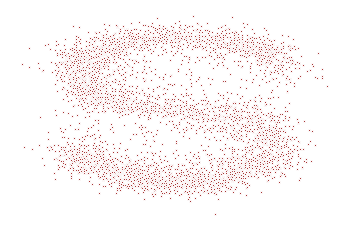

In [333]:
imgs = []
for i in range(1900, 2000):
    plt.clf()
    scatter_point = samples[i].detach().cpu().numpy()
    scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

    scat = plt.scatter(scatter_x, scatter_y,color='brown', edgecolor='white', s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg')
    img = Image.open(img_buf)
    imgs.append(img)

In [334]:
imgs[0].save("ddim.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)

This gif shows the progress of how the sampling works.  
![output](output/ddim/ddim.gif)